In [60]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
import numpy as np
import keras
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn import metrics

In [11]:
# Global Variables
dataset_file = "formatted_data.json"
labels = ['standing',
 'open_guard',
 '5050_guard',
 'turtle',
 'back']

In [13]:
# Convert the JSON entries into a single pandas dataframe, and manipulate the DF to obtain a desirable format
def get_df(dataset_file):    
    df = pd.read_json(dataset_file)
    num_coords = len(df['pose'][0])

    # Create new columns for each x and y coordinate (x1, y1, x2, y2, ...)
    for i in range(num_coords):
        df[f'x{i+1}'] = df['pose'].apply(lambda pose: pose[i][0] if i < len(pose) else None)
        df[f'y{i+1}'] = df['pose'].apply(lambda pose: pose[i][1] if i < len(pose) else None)

    # Drop irrelevant columns
    df.drop('pose', axis=1, inplace=True)
    df.drop('image', axis=1, inplace=True)
    df.drop('frame', axis=1, inplace=True)
    # print(df)
    return df

In [15]:
df = get_df(dataset_file)
df.head(n=5)


,position,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x30,y30,x31,y31,x32,y32,x33,y33,x34,y34
0,standing,449.349365,223.624634,456.961548,216.427673,444.425171,216.028137,466.959351,223.409119,434.879883,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,standing,443.377197,223.846436,451.321045,217.219055,438.394043,216.226257,463.229004,224.034424,431.129883,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,standing,594.297363,60.158508,576.469116,40.562195,607.318970,51.291992,549.377075,28.328278,613.462036,...,755.884277,406.299957,801.395630,499.354401,758.033936,492.391144,789.932983,594.360718,753.618286,589.568604
3,standing,579.405457,62.072754,572.580750,49.764130,606.023987,58.297852,550.683899,41.569580,615.616150,...,747.440430,406.749695,792.947021,503.983276,746.057861,499.627625,782.905518,592.864075,742.696411,593.890076
4,standing,565.223145,57.397522,560.387817,42.238434,587.298218,50.054932,536.931885,37.376099,598.540039,...,733.460876,406.243835,778.929565,502.984619,732.014221,496.920776,769.380493,593.294312,727.832336,594.526489


In [45]:
def seperate_label(df):
    '''
    Seperate labels from features and convert into numpy arrays AND normalize features
    '''
    df_features = df.copy() #x1,y1,x2,y2,x3,y3,...

    df_labels = df_features.pop("position") 
    df_features = np.array(df_features)
    df_labels = np.array(df_labels)
    print(df_features.shape, type(df_features))
    print(df_labels.shape, type(df_labels))
    return normalize(df_features), df_labels # Applying L2 Normalization from SKLearn to dataset

np_features, np_labels = seperate_label(df)

(69781, 68) <class 'numpy.ndarray'>
(69781,) <class 'numpy.ndarray'>


In [46]:
# Conver labels into numbers using SKLearn LabelEncoder
le = LabelEncoder()
# Using .fit_transform function to fit label
# encoder and return encoded label
np_labels = le.fit_transform(np_labels)
 
# printing labels
le.classes_
# Output: array(['5050_guard', 'back', 'open_guard', 'standing', 'turtle'], dtype=object)

array(['5050_guard', 'back', 'open_guard', 'standing', 'turtle'],
      dtype=object)

In [114]:
# Split dataset (25% for testing)
X_train, X_test, y_train, y_test = train_test_split(np_features, np_labels, test_size=0.25, random_state=42)
X_train[0].shape # we have the correct shape

(68,)

## Approach 1 - KNN Classifier

In [49]:
# KNN classifier as a first trial using Sk-learn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [117]:
# Evaluate model with different metrics
y_pred = knn.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
F1 = metrics.f1_score(y_test, y_pred, average='macro')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1", F1)


Accuracy: 0.9963315373151439
Precision: 0.9961064430204493
Recall: 0.9964867544197628
F1 0.996293733300407


## Approach 2 - Dense Neural Network

In [103]:
# Using tensorflow for this model, dense layers with some dropout and regularization to prevent overfitting
model1 = Sequential([
        Dense(units=64, activation='relu', input_shape=(68,)),
        Dense(units=128, activation='relu',
            kernel_regularizer=keras.regularizers.l1_l2(0.03)),
        Dropout(0.3), 
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(units=16, activation='relu', 
            kernel_regularizer=keras.regularizers.l1_l2(0.01)),
        # Dropout(0.3),
        Dense(units=5, activation='softmax')
])

In [104]:
# Loss and optimizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.legacy import Adam

model1.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=["accuracy"])

In [105]:
# We will save the models with the best accuracy. This is done after each epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "checkpoints/DNN1.{epoch:02d}-{val_accuracy:.2f}",
    monitor='accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    #everytime the accuracy gets better, it saves
    save_freq='epoch',
)

In [106]:
history = model1.fit(X_train,y_train, epochs=25, batch_size=64, validation_data=(X_test,y_test), callbacks=[checkpoint])  
# N.B. I could have further split my data to include validation_data=(X_val,y_val) and a seperate test dataset to have a cross-validation set

Epoch 1/25
804/818 [============================>.] - ETA: 0s - loss: 3.1891 - accuracy: 0.5250INFO:tensorflow:Assets written to: checkpoints/DNN1.01-0.71/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.01-0.71/assets


818/818 [==============================] - 2s 2ms/step - loss: 3.1543 - accuracy: 0.5272 - val_loss: 1.0316 - val_accuracy: 0.7125
Epoch 2/25
775/818 [===========================>..] - ETA: 0s - loss: 1.0009 - accuracy: 0.7084INFO:tensorflow:Assets written to: checkpoints/DNN1.02-0.75/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.02-0.75/assets


818/818 [==============================] - 1s 2ms/step - loss: 1.0000 - accuracy: 0.7086 - val_loss: 0.8822 - val_accuracy: 0.7509
Epoch 3/25
805/818 [============================>.] - ETA: 0s - loss: 0.9009 - accuracy: 0.7385INFO:tensorflow:Assets written to: checkpoints/DNN1.03-0.76/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.03-0.76/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.8999 - accuracy: 0.7390 - val_loss: 0.8424 - val_accuracy: 0.7607
Epoch 4/25
770/818 [===========================>..] - ETA: 0s - loss: 0.8326 - accuracy: 0.7557INFO:tensorflow:Assets written to: checkpoints/DNN1.04-0.78/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.04-0.78/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.8307 - accuracy: 0.7566 - val_loss: 0.7568 - val_accuracy: 0.7794
Epoch 5/25
809/818 [============================>.] - ETA: 0s - loss: 0.7866 - accuracy: 0.7715INFO:tensorflow:Assets written to: checkpoints/DNN1.05-0.79/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.05-0.79/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.7867 - accuracy: 0.7712 - val_loss: 0.7349 - val_accuracy: 0.7875
Epoch 6/25
805/818 [============================>.] - ETA: 0s - loss: 0.7345 - accuracy: 0.7932INFO:tensorflow:Assets written to: checkpoints/DNN1.06-0.80/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.06-0.80/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.7346 - accuracy: 0.7933 - val_loss: 0.6678 - val_accuracy: 0.8042
Epoch 7/25
778/818 [===========================>..] - ETA: 0s - loss: 0.7022 - accuracy: 0.8040INFO:tensorflow:Assets written to: checkpoints/DNN1.07-0.81/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.07-0.81/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.7017 - accuracy: 0.8044 - val_loss: 0.6628 - val_accuracy: 0.8124
Epoch 8/25
802/818 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.8252INFO:tensorflow:Assets written to: checkpoints/DNN1.08-0.87/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.08-0.87/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.6618 - accuracy: 0.8254 - val_loss: 0.5722 - val_accuracy: 0.8716
Epoch 9/25
788/818 [===========================>..] - ETA: 0s - loss: 0.6304 - accuracy: 0.8396INFO:tensorflow:Assets written to: checkpoints/DNN1.09-0.88/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.09-0.88/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.6294 - accuracy: 0.8399 - val_loss: 0.5291 - val_accuracy: 0.8838
Epoch 10/25
774/818 [===========================>..] - ETA: 0s - loss: 0.6089 - accuracy: 0.8474INFO:tensorflow:Assets written to: checkpoints/DNN1.10-0.88/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.10-0.88/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.6065 - accuracy: 0.8483 - val_loss: 0.5335 - val_accuracy: 0.8777
Epoch 11/25
777/818 [===========================>..] - ETA: 0s - loss: 0.5790 - accuracy: 0.8550INFO:tensorflow:Assets written to: checkpoints/DNN1.11-0.89/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.11-0.89/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.5795 - accuracy: 0.8549 - val_loss: 0.4919 - val_accuracy: 0.8933
Epoch 12/25
769/818 [===========================>..] - ETA: 0s - loss: 0.5560 - accuracy: 0.8646INFO:tensorflow:Assets written to: checkpoints/DNN1.12-0.89/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.12-0.89/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.5560 - accuracy: 0.8646 - val_loss: 0.4807 - val_accuracy: 0.8945
Epoch 13/25
783/818 [===========================>..] - ETA: 0s - loss: 0.5469 - accuracy: 0.8680INFO:tensorflow:Assets written to: checkpoints/DNN1.13-0.88/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.13-0.88/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.5456 - accuracy: 0.8684 - val_loss: 0.4901 - val_accuracy: 0.8824
Epoch 14/25
780/818 [===========================>..] - ETA: 0s - loss: 0.5382 - accuracy: 0.8712INFO:tensorflow:Assets written to: checkpoints/DNN1.14-0.91/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.14-0.91/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.5373 - accuracy: 0.8717 - val_loss: 0.4530 - val_accuracy: 0.9060
Epoch 15/25
813/818 [============================>.] - ETA: 0s - loss: 0.5229 - accuracy: 0.8757INFO:tensorflow:Assets written to: checkpoints/DNN1.15-0.90/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.15-0.90/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.8756 - val_loss: 0.4409 - val_accuracy: 0.9027
Epoch 16/25
768/818 [===========================>..] - ETA: 0s - loss: 0.5090 - accuracy: 0.8790INFO:tensorflow:Assets written to: checkpoints/DNN1.16-0.87/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.16-0.87/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.5081 - accuracy: 0.8793 - val_loss: 0.5021 - val_accuracy: 0.8666
Epoch 17/25
818/818 [==============================] - 1s 1ms/step - loss: 0.5026 - accuracy: 0.8785 - val_loss: 0.4273 - val_accuracy: 0.9052
Epoch 18/25
774/818 [===========================>..] - ETA: 0s - loss: 0.4977 - accuracy: 0.8800INFO:tensorflow:Assets written to: checkpoints/DNN1.18-0.92/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.18-0.92/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.4993 - accuracy: 0.8799 - val_loss: 0.4126 - val_accuracy: 0.9158
Epoch 19/25
769/818 [===========================>..] - ETA: 0s - loss: 0.4953 - accuracy: 0.8814INFO:tensorflow:Assets written to: checkpoints/DNN1.19-0.91/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.19-0.91/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.4965 - accuracy: 0.8809 - val_loss: 0.4087 - val_accuracy: 0.9125
Epoch 20/25
770/818 [===========================>..] - ETA: 0s - loss: 0.4837 - accuracy: 0.8839INFO:tensorflow:Assets written to: checkpoints/DNN1.20-0.92/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.20-0.92/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.4825 - accuracy: 0.8845 - val_loss: 0.3964 - val_accuracy: 0.9199
Epoch 21/25
792/818 [============================>.] - ETA: 0s - loss: 0.4804 - accuracy: 0.8857INFO:tensorflow:Assets written to: checkpoints/DNN1.21-0.92/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.21-0.92/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.4805 - accuracy: 0.8855 - val_loss: 0.3776 - val_accuracy: 0.9223
Epoch 22/25
818/818 [==============================] - 1s 1ms/step - loss: 0.4865 - accuracy: 0.8828 - val_loss: 0.4149 - val_accuracy: 0.9069
Epoch 23/25
818/818 [==============================] - 1s 1ms/step - loss: 0.4786 - accuracy: 0.8849 - val_loss: 0.3919 - val_accuracy: 0.9136
Epoch 24/25
796/818 [============================>.] - ETA: 0s - loss: 0.4687 - accuracy: 0.8875INFO:tensorflow:Assets written to: checkpoints/DNN1.24-0.92/assets


INFO:tensorflow:Assets written to: checkpoints/DNN1.24-0.92/assets


818/818 [==============================] - 1s 2ms/step - loss: 0.4687 - accuracy: 0.8876 - val_loss: 0.3680 - val_accuracy: 0.9239
Epoch 25/25
818/818 [==============================] - 1s 1ms/step - loss: 0.4778 - accuracy: 0.8837 - val_loss: 0.3690 - val_accuracy: 0.9248


In [107]:
model1.evaluate(X_test,y_test)

  1/546 [..............................] - ETA: 7s - loss: 0.3978 - accuracy: 0.9062

546/546 [==============================] - 0s 476us/step - loss: 0.3690 - accuracy: 0.9248


[0.3690263628959656, 0.9247965216636658]

In [108]:
# Get more information about metrics - I also could have used a confusion matrix to better visualize the data
y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming your model outputs probabilities per class
y_pred_classes
print(metrics.classification_report(y_test, y_pred_classes)) # From Sk-learn

546/546 [==============================] - 0s 367us/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2104
           1       0.88      0.90      0.89      3343
           2       0.94      0.87      0.90      3765
           3       0.95      0.97      0.96      4138
           4       0.95      0.95      0.95      4096

    accuracy                           0.92     17446
   macro avg       0.92      0.92      0.92     17446
weighted avg       0.93      0.92      0.92     17446



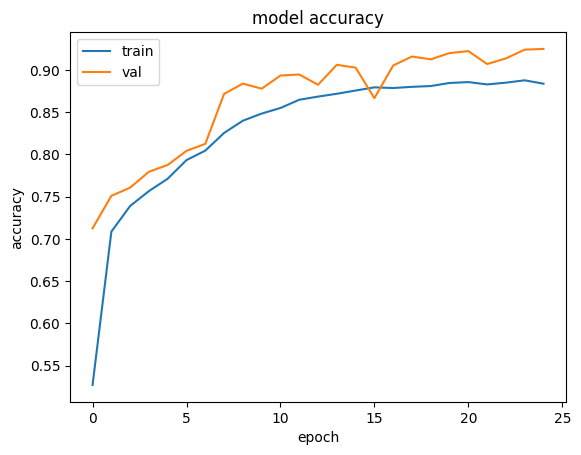

In [110]:
# Plotting - images saved in results directory
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('results/model1_5_positions_accuracy.png')
plt.show()

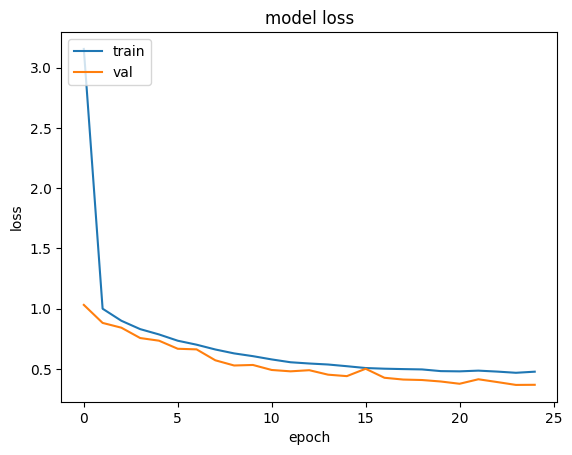

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('results/model1_5_positions_loss.png')
plt.show()

# Approach 3 - LSTMs and Time Series Data with Dynamic Time Warping

Since we have access to the frame number in each entry of our dataset, we can use this information as well as the name of the position to create a time series dataset. A sequence of consecutive frames for the same position will be a time series.

After that, we can train our data on a LSTM model, but before we will make sure that there is some form of masking or padding.

This is a more efficient strategy to implement if we were to use the model on analyzing videos, since BJJ positions can involve motion, and and LSTM would be a good fit to track such motion 

Additionally, for preprocessing, we could also apply Dynamic Time Warping, which is an algorithm used to measure the similarity between two temporal sequences which may vary in time or speed. It can be useful for time-series data, especially when dealing with sequences of varying lengths or speeds.

### Applications:

<b>Sequence Alignment:</b> In datasets where the sequences are not perfectly aligned in time, DTW can help by aligning them based on their shape and pattern.
<br>
<br>
<b>Feature Engineering:</b> DTW can be used to create new features. For example, the DTW distance between a given sequence and some reference sequence can be a powerful feature that encodes the similarity of that sequence to a known pattern (e.g. a master of BJJ could be the reference).